# Projet

### Imports

In [156]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets
import matplotlib.pyplot as plt
import numpy
from sklearn.cluster import KMeans
from random import randint

## 1. Collecte de données

### Dataframe Functions

In [144]:
def jsonToDataframe(path):   
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def dataframeToJson(path, dataframe):   
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### Récupération du résultat d'une query Wikidata

In [145]:
size = 20
dataPath = "data.json"
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()

# On normalise les résultat pour pandas
array = []
for data in results["results"]["bindings"]:
    name = data["itemLabel"]["value"]
    format = data["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"

    array.append([name,  
                  data["pic"]["value"], 
                  data["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument']])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags"])

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)

# Nettoyage du dossier /images
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)



dataframe


,label,link,entityID,format,path,size,sizeCategory,tags
0,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,(),None,[#monument]
1,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,(),None,[#monument]
2,Castillo de la Luz,http://commons.wikimedia.org/wiki/Special:File...,Q1049274,jpg,./images/Castillo de la Luz.jpg,(),None,[#monument]
3,Castillo de Valencia de Don Juan,http://commons.wikimedia.org/wiki/Special:File...,Q1049275,jpg,./images/Castillo de Valencia de Don Juan.jpg,(),None,[#monument]
4,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,(),None,[#monument]
5,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,(),None,[#monument]
6,Palacio de la Condesa de Lebrija,http://commons.wikimedia.org/wiki/Special:File...,Q1064212,JPG,./images/Palacio de la Condesa de Lebrija.JPG,(),None,[#monument]
7,Monument aux Girondins,http://commons.wikimedia.org/wiki/Special:File...,Q1064990,JPG,./images/Monument aux Girondins.JPG,(),None,[#monument]
8,Chartered Company Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1067824,jpg,./images/Chartered Company Monument.jpg,(),None,[#monument]
9,Cho Huan Lai Memorial,http://commons.wikimedia.org/wiki/Special:File...,Q1075516,jpg,./images/Cho Huan Lai Memorial.jpg,(),None,[#monument]


### Téléchargement des Images

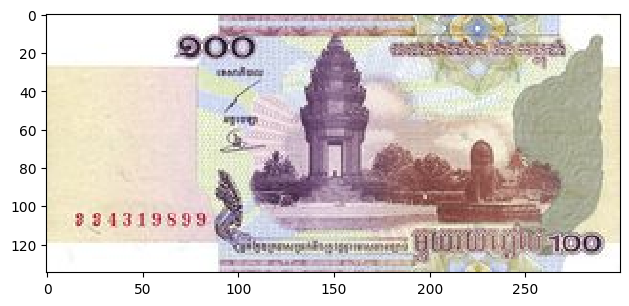

In [146]:
dataframe = jsonToDataframe(dataPath)
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [147]:
dataframe = jsonToDataframe(dataPath)

wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "dateTaken", 'appareil']

for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcours les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
dataframeToJson(dataPath, dataframe)
        
dataframe 

,label,link,entityID,format,path,size,sizeCategory,tags,orientation,artist,dateTaken,appareil
0,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,"(4000, 3000)",NaN,[#monument],1,ANGEL CAMINERO,2015:05:18 13:54:21,Canon PowerShot G9
1,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,"(4000, 3000)",NaN,[#monument],1,ANGEL CAMINERO,2015:05:18 13:54:21,Canon PowerShot G9
2,Castillo de la Luz,http://commons.wikimedia.org/wiki/Special:File...,Q1049274,jpg,./images/Castillo de la Luz.jpg,"(7219, 3753)",NaN,[#monument],1,None,2017:01:17 15:46:25,NIKON D810
3,Castillo de Valencia de Don Juan,http://commons.wikimedia.org/wiki/Special:File...,Q1049275,jpg,./images/Castillo de Valencia de Don Juan.jpg,"(2070, 2448)",NaN,[#monument],1,None,2011:06:25 19:59:46,FinePix F480
4,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,"(4000, 2664)",NaN,[#monument],1,None,2017:06:02 16:28:37,Canon PowerShot SX50 HS
5,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,"(4000, 2664)",NaN,[#monument],1,None,2017:06:02 16:28:37,Canon PowerShot SX50 HS
6,Palacio de la Condesa de Lebrija,http://commons.wikimedia.org/wiki/Special:File...,Q1064212,JPG,./images/Palacio de la Condesa de Lebrija.JPG,"(1728, 2304)",NaN,[#monument],0,None,2007:03:11 13:29:53,DSC-P73
7,Monument aux Girondins,http://commons.wikimedia.org/wiki/Special:File...,Q1064990,JPG,./images/Monument aux Girondins.JPG,"(1536, 2048)",NaN,[#monument],0,None,2009:07:21 19:16:36,E3200
8,Chartered Company Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1067824,jpg,./images/Chartered Company Monument.jpg,"(1200, 1800)",NaN,[#monument],0,CEphoto; Uwe Aranas,2012:09:09 21:52:32,DSLR-A700
9,Cho Huan Lai Memorial,http://commons.wikimedia.org/wiki/Special:File...,Q1075516,jpg,./images/Cho Huan Lai Memorial.jpg,"(1200, 1800)",NaN,[#monument],0,CEphoto; Uwe Aranas,2012:09:30 12:28:15,DSLR-A700


### Kmeans et Couleurs dominantes

In [148]:
dataframe = jsonToDataframe(dataPath)
dataframe["dColors"] = None
dataframe["dProportions"] = None

nColors = 6
laziness = 100

kmeans = KMeans(n_clusters=nColors, random_state=0, n_init="auto")


for i, path in enumerate(dataframe["path"]):
    img = PIL.Image.open(path).convert('RGB')
    pixelData = numpy.array(img).reshape(-1, 3)[::laziness]
    kmeans.fit(pixelData)

    proportions = numpy.array([0 for i in range(nColors)])
    for x in kmeans.labels_:
        proportions[x] += numpy.float64(1)
    proportions = proportions / kmeans.labels_.size

    dataframe.at[i,"dColors"] = numpy.int32(kmeans.cluster_centers_)
    dataframe.at[i,"dProportions"] = proportions
    
dataframeToJson(dataPath, dataframe)
dataframe



,label,link,entityID,format,path,size,sizeCategory,tags,orientation,artist,dateTaken,appareil,dColors,dProportions
0,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,"[4000, 3000]",NaN,[#monument],1,ANGEL CAMINERO,2015:05:18 13:54:21,Canon PowerShot G9,"[[130, 118, 100], [92, 86, 61], [83, 149, 228]...","[0.166225, 0.19656666666666667, 0.342091666666..."
1,Castillo La Iruela,http://commons.wikimedia.org/wiki/Special:File...,Q1049272,jpg,./images/Castillo La Iruela.jpg,"[4000, 3000]",NaN,[#monument],1,ANGEL CAMINERO,2015:05:18 13:54:21,Canon PowerShot G9,"[[130, 118, 100], [92, 86, 61], [83, 149, 228]...","[0.166225, 0.19656666666666667, 0.342091666666..."
2,Castillo de la Luz,http://commons.wikimedia.org/wiki/Special:File...,Q1049274,jpg,./images/Castillo de la Luz.jpg,"[7219, 3753]",NaN,[#monument],1,None,2017:01:17 15:46:25,NIKON D810,"[[126, 120, 122], [208, 223, 238], [166, 184, ...","[0.13349942789650462, 0.40801313992544197, 0.0..."
3,Castillo de Valencia de Don Juan,http://commons.wikimedia.org/wiki/Special:File...,Q1049275,jpg,./images/Castillo de Valencia de Don Juan.jpg,"[2070, 2448]",NaN,[#monument],1,None,2011:06:25 19:59:46,FinePix F480,"[[137, 125, 96], [152, 194, 220], [193, 176, 1...","[0.11289813316493666, 0.12244938232624225, 0.0..."
4,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,"[4000, 2664]",NaN,[#monument],1,None,2017:06:02 16:28:37,Canon PowerShot SX50 HS,"[[20, 27, 17], [137, 164, 190], [103, 100, 95]...","[0.1477665165165165, 0.40910285285285286, 0.16..."
5,China Millennium Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1056441,jpg,./images/China Millennium Monument.jpg,"[4000, 2664]",NaN,[#monument],1,None,2017:06:02 16:28:37,Canon PowerShot SX50 HS,"[[20, 27, 17], [137, 164, 190], [103, 100, 95]...","[0.1477665165165165, 0.40910285285285286, 0.16..."
6,Palacio de la Condesa de Lebrija,http://commons.wikimedia.org/wiki/Special:File...,Q1064212,JPG,./images/Palacio de la Condesa de Lebrija.JPG,"[1728, 2304]",NaN,[#monument],0,None,2007:03:11 13:29:53,DSC-P73,"[[39, 31, 27], [190, 171, 155], [254, 253, 252...","[0.23546993519867385, 0.09730245642236399, 0.0..."
7,Monument aux Girondins,http://commons.wikimedia.org/wiki/Special:File...,Q1064990,JPG,./images/Monument aux Girondins.JPG,"[1536, 2048]",NaN,[#monument],0,None,2009:07:21 19:16:36,E3200,"[[54, 64, 45], [183, 196, 207], [100, 105, 98]...","[0.06081124038400407, 0.33737046220357303, 0.0..."
8,Chartered Company Monument,http://commons.wikimedia.org/wiki/Special:File...,Q1067824,jpg,./images/Chartered Company Monument.jpg,"[1200, 1800]",NaN,[#monument],0,CEphoto; Uwe Aranas,2012:09:09 21:52:32,DSLR-A700,"[[25, 27, 17], [178, 176, 172], [94, 89, 82], ...","[0.20587962962962963, 0.36898148148148147, 0.1..."
9,Cho Huan Lai Memorial,http://commons.wikimedia.org/wiki/Special:File...,Q1075516,jpg,./images/Cho Huan Lai Memorial.jpg,"[1200, 1800]",NaN,[#monument],0,CEphoto; Uwe Aranas,2012:09:30 12:28:15,DSLR-A700,"[[82, 83, 40], [234, 218, 205], [32, 36, 13], ...","[0.16152777777777777, 0.22171296296296297, 0.2..."


## Analyse des Données

In [163]:
# Création de la dataframe des utilisateurs
usersPath = 'users.json'

array = [['default',[]]]
usersDataframe = pandas.DataFrame(array, columns=['username', 'likedImages'])

for i in range(7) :
    num = randint(0,len(jsonToDataframe(dataPath)['label']))
    while num in usersDataframe.at[0,"likedImages"]:
        num = randint(0,len(jsonToDataframe(dataPath)['label']))
    usersDataframe.at[0,"likedImages"].append(num)

dataframeToJson(usersPath, usersDataframe)

usersDataframe

,username,likedImages
0,default,"[10, 5, 12, 2, 3, 19, 13]"


In [164]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

data = numpy.array(jsonToDataframe(dataPath)[['tags','orientation']])[:-1]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i][j] = str(data[i][j])


likedImages = jsonToDataframe(usersPath)["likedImages"][0]
result = numpy.array([str(i in likedImages) for i in range(len(data))])


# Encode categorical features and labels
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = result  # Labels


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
sample_item = numpy.array(jsonToDataframe(dataPath)[['tags','orientation']])[-1]
sample_item = [str(attribute) for attribute in sample_item]

encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
prediction = classifier.predict([encoded_item])[0]
print(f"Prediction for the sample item: {prediction}")


Accuracy: 0.75
Prediction for the sample item: False


## Test Interaction

In [151]:
images = glob.glob('./images/*')
images

['./images\\Brunswick Monument.jpg',
 './images\\Castillo de la Luz.jpg',
 './images\\Castillo de Valencia de Don Juan.jpg',
 './images\\Castillo La Iruela.jpg',
 './images\\Chartered Company Monument.jpg',
 './images\\China Millennium Monument.jpg',
 './images\\Cho Huan Lai Memorial.jpg',
 './images\\Chronos und die Trauernde.jpg',
 './images\\church of San Miguel.jpg',
 './images\\Iglesia de San Lorenzo Mártir.jpg',
 './images\\Independence Monument, Phnom Penh.jpg',
 './images\\Kriegsgräberstätte bei Treuchtlingen.jpg',
 './images\\Monument aux Girondins.JPG',
 './images\\Monument to the Peaceful Liberation of Tibet.jpg',
 './images\\monument to Yuri Gagarin.jpg',
 './images\\Palacio de la Condesa de Lebrija.JPG',
 './images\\Puerta del Puente.JPG',
 './images\\Q1077945.jpg']

In [152]:
layout =  ipywidgets.GridspecLayout(n_columns=3, n_rows=len(images), height='400px')

children = [[],[]]
for i, img in enumerate(images):
  with open(img, "rb") as f :
    img = f.read()

    layout = ipywidgets.widgets.Layout(display = 'flex')
    imageLayout = ipywidgets.widgets.Layout(display = 'flex', width = '75%')
    checkBoxLayout = ipywidgets.widgets.Layout(display = 'flex')
    checkBox = ipywidgets.Checkbox(layout = checkBoxLayout)
    
    ImageBox = ipywidgets.Box([ipywidgets.widgets.Image(value=img, layout = imageLayout),checkBox], layout = layout)
    children[i%2].append(ImageBox)

# Customize your layout here:
box_layout = ipywidgets.widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    width='50%')

# Create the widget
box1 = ipywidgets.widgets.Box(layout = box_layout)
box1.children = children[0]
box2 = ipywidgets.widgets.Box(layout = box_layout)
box2.children = children[1]

ipywidgets.HBox([box1,box2])

## Visualisation des Données

<BarContainer object of 9 artists>

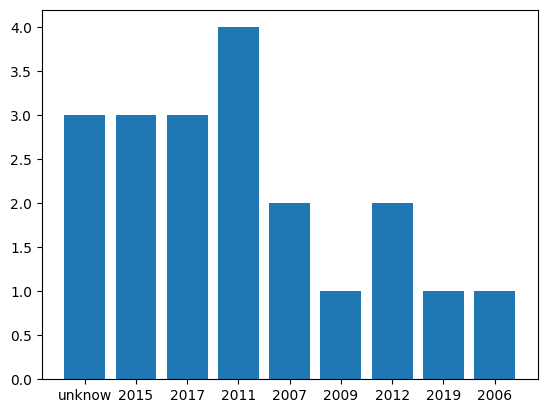

In [153]:
dataframe = jsonToDataframe(dataPath)

sources = {'year':'dateTaken', 'orientation':'orientation'}
criteria = ''
while criteria not in sources :
    criteria = input('criteria :')


categories = ['unknow']
cardinals  = [0]


for i in range(len(dataframe.index)):
    value = str(dataframe._get_value(i, sources[criteria]))

    if value != 'None':
        if criteria == 'year':
            value = value.split(':')[0].strip()
        elif criteria == 'orientation':
            value = {'0':"Portrait", '1':"Landscape"}[value]

        if value in categories:
            cardinals[categories.index(value)] += 1
        else:
            categories.append(value)
            cardinals.append(1)
    else:
        cardinals[0] += 1


plt.bar(categories, cardinals)

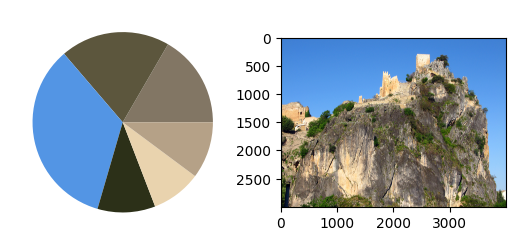

In [154]:
dataframe = jsonToDataframe(dataPath)

imageIndex = 0

fig, ax = plt.subplots(1,2)

ax[0].pie(dataframe.at[imageIndex,"dProportions"], colors=(numpy.array(dataframe.at[imageIndex, "dColors"])/255))
ax[1].imshow(PIL.Image.open(dataframe.at[imageIndex, "path"]))
